<h1><center>🍎 Apple Foliar Disease Detector 💡</center></h1>

# Welcome!

In [246]:
"Welcome to my Kaggle Notebook for my DIP Project AFD Detector"

'Welcome to my Kaggle Notebook for my DIP Project AFD Detector'

# Paths Veriables
- Train Images
- Test Images
- Train Labels CSV
- Sample Submission CSV
- Output Path

In [247]:
train_images_path = "/kaggle/input/plant-pathology-2021-fgvc8/train_images"
test_images_path = "/kaggle/input/plant-pathology-2021-fgvc8/test_images"
train_csv_path = "/kaggle/input/plant-pathology-2021-fgvc8/train.csv"
submission_csv_path = "/kaggle/input/plant-pathology-2021-fgvc8/sample_submission.csv"
output_path = "/kaggle/working/"

# Imports

In [316]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pydot
import tensorflow as tf


import cv2
import multiprocessing
from tqdm import tqdm
import shutil

import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

# Train and Test Images Count

In [249]:
number_of_train_images = os.listdir(train_images_path)
print("Train Images Count: ", len(number_of_train_images))

number_of_test_images = os.listdir(test_images_path)
print("Test Images Count: ", len(number_of_test_images))

Train Images Count:  18632
Test Images Count:  3


# CSV Files Lookup
- **Train Labels CSV**

In [250]:
train_label_df = pd.read_csv(train_csv_path)
train_label_df

image                           labels
0      800113bb65efe69e.jpg                          healthy
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex
2      80070f7fb5e2ccaa.jpg                             scab
3      80077517781fb94f.jpg                             scab
4      800cbf0ff87721f8.jpg                          complex
...                     ...                              ...
18627  fffb900a92289a33.jpg                          healthy
18628  fffc488fa4c0e80c.jpg                             scab
18629  fffc94e092a59086.jpg                             rust
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot
18631  fffe472a0001bd25.jpg                          healthy

[18632 rows x 2 columns]

- **Sample Submission CSV**

In [251]:
sample_submission_df = pd.read_csv(submission_csv_path)
sample_submission_df

image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy

# Know the Label

In [252]:
def get_label(image_name):
    return train_label_df[train_label_df['image'] == image_name].iloc[0, 1]

get_label('800113bb65efe69e.jpg')

'healthy'

# Display Test Images Sample

In [253]:
def display_train_sample(sample_size):
    samples = train_label_df.sample(sample_size)
        
    rows = (sample_size // 3) + 1
    columns = 3
    
    plt.figure(figsize=(22, 20))
        
    for i in range(sample_size):
        image_name = samples.iloc[i,0]
        image_disease_title = samples.iloc[i,1]
        
        train_sample_path = os.path.join(train_images_path, image_name)
        
        train_sample = cv2.imread(train_sample_path)
        train_sample = cv2.cvtColor(train_sample, cv2.COLOR_BGR2RGB)
        
        plt.subplot(rows, columns, i + 1)
        
        plt.imshow(train_sample)
        plt.title(image_disease_title)
        plt.axis("off")
        
    plt.show()

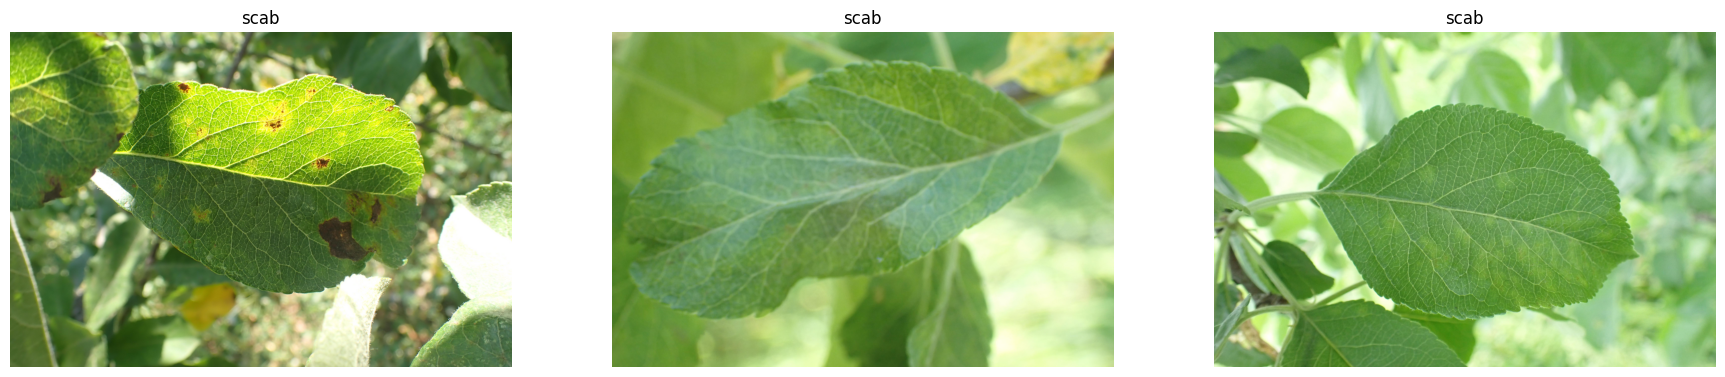

In [254]:
display_train_sample(3)

# Disease Class Distribution

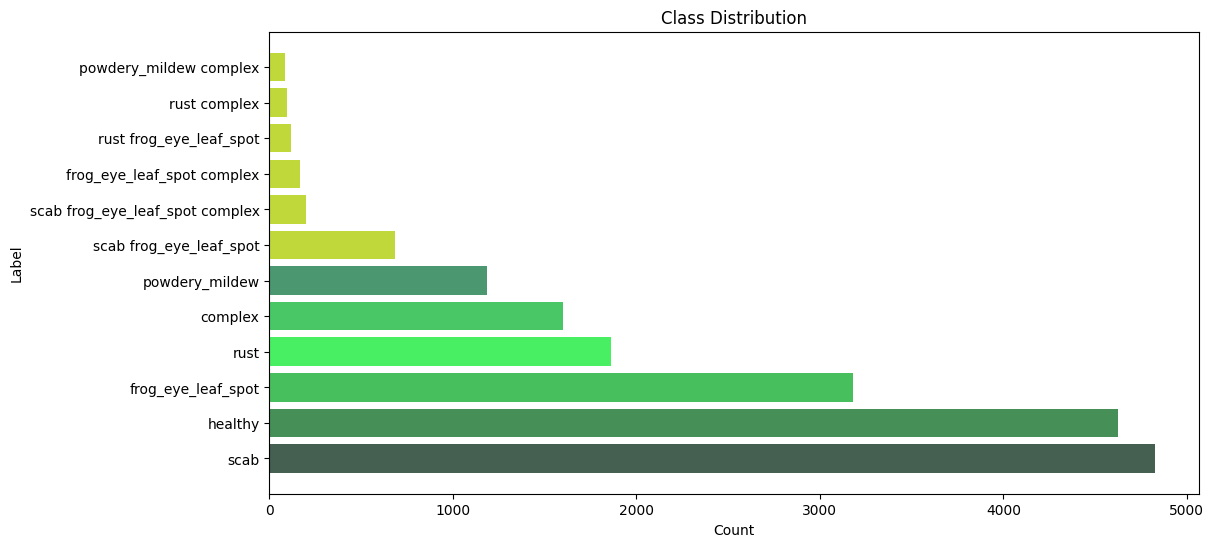

In [255]:
label_dist = train_label_df.iloc[:, [1]].value_counts()

label_dist_df = label_dist.reset_index()
label_dist_df.columns = ['Label', 'Count']

colors = [
    '#455F51',
    '#468F57',
    '#47BF5D',
    '#48EF63',
    '#49C766',
    '#4A9770',
    '#C0D83A',
    '#C0D83A',
    '#C0D83A',
    '#C0D83A',
    '#C0D83A',
    '#C0D83A'
]

plt.figure(figsize=(12, 6))

plt.barh(label_dist_df['Label'], label_dist_df['Count'], color=colors)
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Class Distribution')
plt.show()

# Leaf Condition Check

In [256]:
def leaf_condtion(sample_size, target_disease):
    diseases = [
        "scab",
        "healthy",
        "frog_eye_leaf_spot",
        "rust",
        "complex",
        "powdery_mildew",
        "scab frog_eye_leaf_spot",
        "scab frog_eye_leaf_spot complex",
        "frog_eye_leaf_spot complex",
        "rust frog_eye_leaf_spot",
        "rust complex",
        "powdery_mildew complex"
    ]
    
    filtered_df = train_label_df[train_label_df['labels'] == diseases[target_disease - 1]]
    samples = filtered_df.sample(sample_size)
    
    rows = (sample_size // 3) + 1
    columns = 3
    
    plt.figure(figsize=(22, 20))
    
    for i in range(sample_size):
        image_name = samples.iloc[i,0]
        image_disease_title = samples.iloc[i,1]
        
        train_sample_path = os.path.join(train_images_path, image_name)
        
        train_sample = cv2.imread(train_sample_path)
        train_sample = cv2.cvtColor(train_sample, cv2.COLOR_BGR2RGB)                
        
        plt.subplot(rows, columns, i + 1)
        
        plt.imshow(train_sample)
        plt.title(image_disease_title)
        plt.axis("off")
        
    plt.show()

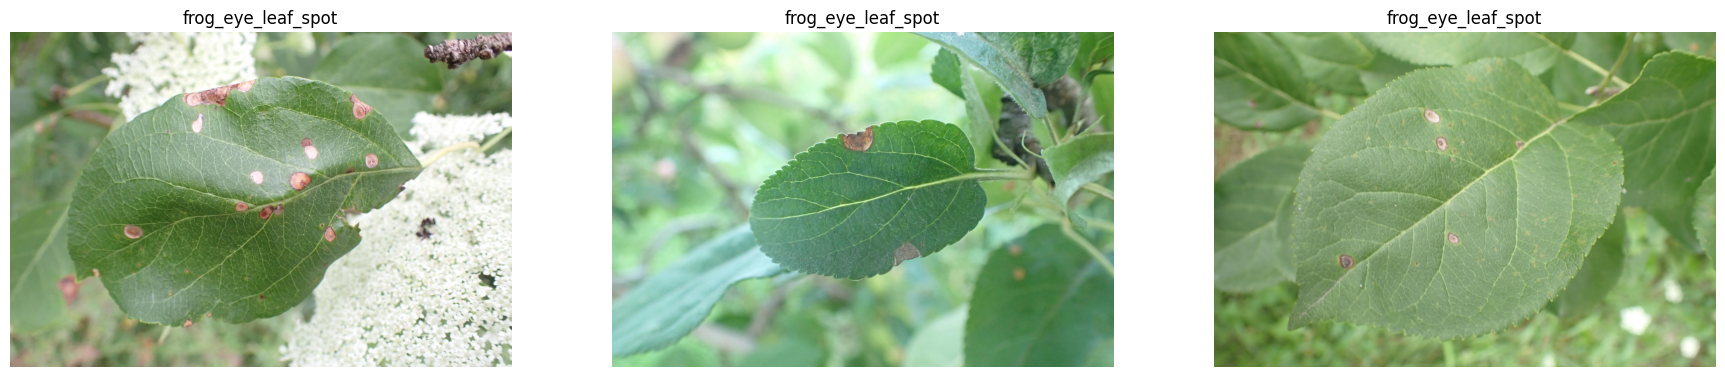

In [257]:
# Disease categories:
# 1. "scab",
# 2. "healthy",
# 3. "frog_eye_leaf_spot",
# 4. "rust",
# 5. "complex",
# 6. "powdery_mildew",
# 7. "scab frog_eye_leaf_spot",
# 8. "scab frog_eye_leaf_spot complex",
# 9. "frog_eye_leaf_spot complex",
# 10. "rust frog_eye_leaf_spot",
# 11. "rust complex",
# 12. "powdery_mildew complex"

leaf_condtion(sample_size=3, target_disease=3)

# Sharpening

In [258]:
def sharp(image_path):
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

#     image = image_path
    
    plt.figure(figsize=(12, 8))

    # Display the original image on the left
    plt.subplot(2, 2, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')
    
    # Sharpening kernel (Laplacian kernel 3 x 3)
    kernel_1 = np.array([[0, -1, 0],
                       [-1, 5, -1],
                       [0, -1, 0]], dtype=np.float32)
    
    # Sharpening kernel (Laplacian kernel 5 x 5)
    kernel_2 = np.array([[-1, -1, -1, -1, -1],
                       [-1, -1, -1, -1, -1],
                       [-1, -1, 25, -1, -1],
                       [-1, -1, -1, -1, -1],
                       [-1, -1, -1, -1, -1]], dtype=np.float32)
    
    # Sharpening kernel (Unsharp Mask)
    kernel_3 = np.array([[-1, -1, -1],
                       [-1, 9, -1],
                       [-1, -1, -1]], dtype=np.float32)
    
    kernels = [kernel_1, kernel_2, kernel_3]
#     kernels = [kernel_3]
    kernel_titles = ['Laplacian kernel 3 x 3', 'Laplacian kernel 5 x 5', 'Unsharp Mask']

    # Split the RGB image into its individual color channels
    r, g, b = cv2.split(image)

    for i, kernel in enumerate(kernels):
        # Apply the sharpening filter to each channel separately
        r_sharpened = cv2.filter2D(r, -1, kernel)
        g_sharpened = cv2.filter2D(g, -1, kernel)
        b_sharpened = cv2.filter2D(b, -1, kernel)

        # Merge the sharpened channels back into an RGB image
        sharpened_image = cv2.merge((r_sharpened, g_sharpened, b_sharpened))

        # Display the sharpened image on the right
        plt.subplot(2, 2, i + 2)
        plt.imshow(sharpened_image)
        plt.title(f"{kernel_titles[i]} - {get_label(image_path.split('/')[-1])}")
        plt.axis('off')

    # Show the figure
    plt.show()
#     return sharpened_image

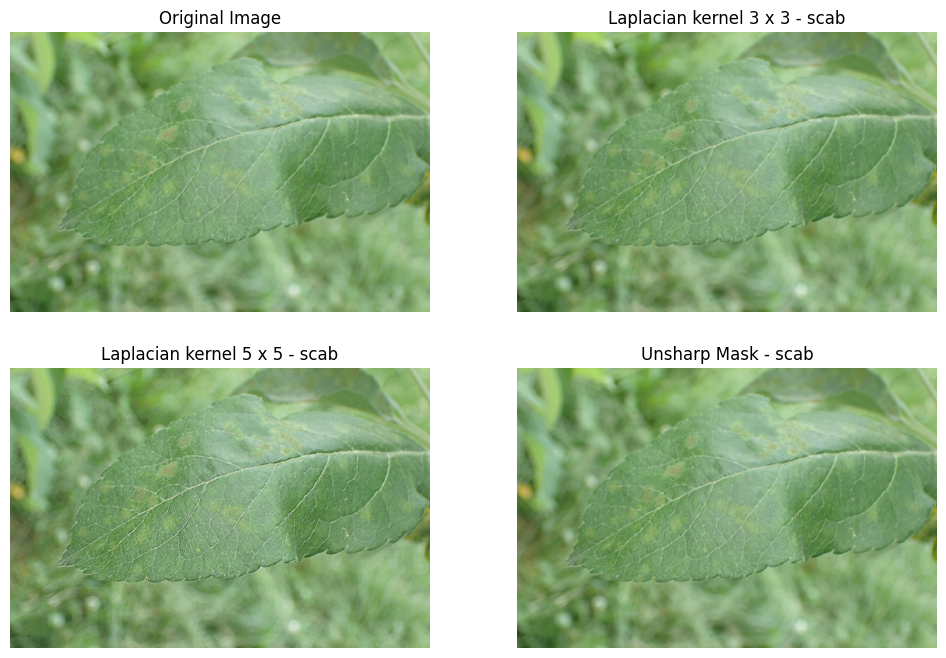

In [315]:
random_image = train_label_df.sample(1).iloc[0, 0]
image_path = os.path.join(train_images_path, random_image)
sharp(image_path)

# Histogram Equalization

In [260]:
def equalize_hist(image_path):    
    # Load the RGB image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Split the image into its color channels (B, G, R)
    b, g, r = cv2.split(image)

    # Apply histogram equalization to each color channel
    equalized_b = cv2.equalizeHist(b)
    equalized_g = cv2.equalizeHist(g)
    equalized_r = cv2.equalizeHist(r)

    # Merge the equalized channels back into a color image
    equalized_image = cv2.merge((equalized_b, equalized_g, equalized_r))

    plt.figure(figsize=(12, 8))
    
    # Plot Orignal image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image - {get_label(image_path.split("/")[-1])}')
    plt.axis('off')

    # Plot equalized image
    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image)
    plt.title(f'Equalized Image  - {get_label(image_path.split("/")[-1])}') 
    plt.axis('off')

    plt.suptitle("Global Histogram Equalization in RGB Space")
    plt.subplots_adjust(top=1.3)
    plt.show()

In [261]:
def equalize_hist_lab(image_path):    
    # Load the RGB image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert the image from RGB to LAB color space
    image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels (L, A, B)
    l, a, b = cv2.split(image_lab)

    # Apply histogram equalization to the L channel only
    equalized_l = cv2.equalizeHist(l)

    # Merge the equalized L channel back with the A and B channels
    equalized_lab = cv2.merge((equalized_l, a, b))

    # Convert the LAB image back to RGB color space
    equalized_image_rgb = cv2.cvtColor(equalized_lab, cv2.COLOR_LAB2RGB)

    plt.figure(figsize=(12, 8))
    
    # Plot Original image
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title(f'Original Image - {get_label(image_path.split("/")[-1])}')
    plt.axis('off')

    # Plot equalized image
    plt.subplot(1, 2, 2)
    plt.imshow(equalized_image_rgb)
    plt.title(f'Equalized Image - {get_label(image_path.split("/")[-1])}') 
    plt.axis('off')

    plt.suptitle("Global Histogram Equalization in LAB Space")
    plt.subplots_adjust(top=1.3)
    plt.show()

# Local Histogram Equalization

In [262]:
def equalize_local_hist(image_path):
    # Step 1: Load the color image
    image_color = cv2.imread(image_path)
    image_color = cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB)

#     image_color = image_path
    
    # Step 2: Convert the image from RGB to LAB color space
    image_lab = cv2.cvtColor(image_color, cv2.COLOR_RGB2LAB)

    # Step 3: Apply CLAHE to the L (luminance) channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    L, a, b = cv2.split(image_lab)
    L_equalized = clahe.apply(L)
    image_lab_equalized = cv2.merge([L_equalized, a, b])

    # Step 4: Convert the LAB image back to RGB
    image_color_equalized = cv2.cvtColor(image_lab_equalized, cv2.COLOR_LAB2RGB)

    # Step 5: Display the original and equalized images
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(image_color)
    plt.title(f'Original Image - {get_label(image_path.split("/")[-1])}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(image_color_equalized)
    plt.title(f'Equalized Image - {get_label(image_path.split("/")[-1])}')
    plt.axis('off')

    plt.suptitle("Local Histogram Equalization in LAB Space")
    plt.subplots_adjust(top=1.11)
    plt.show()

#     return image_color_equalized

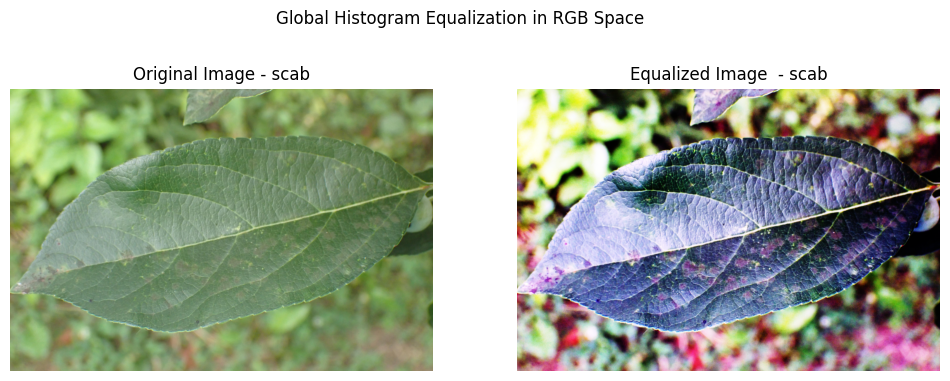

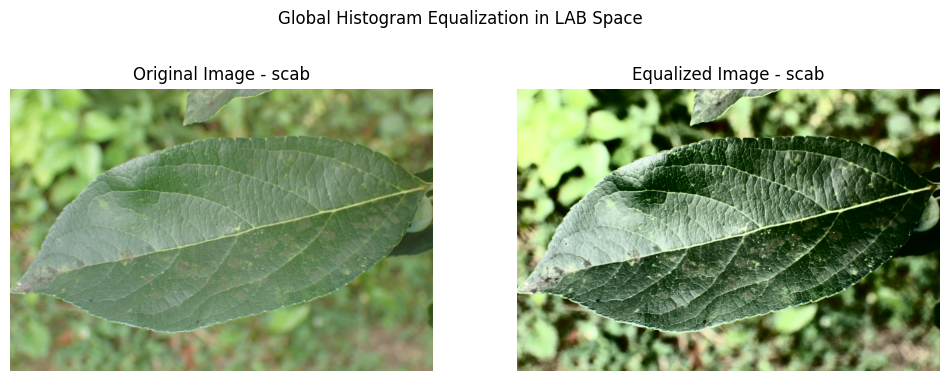

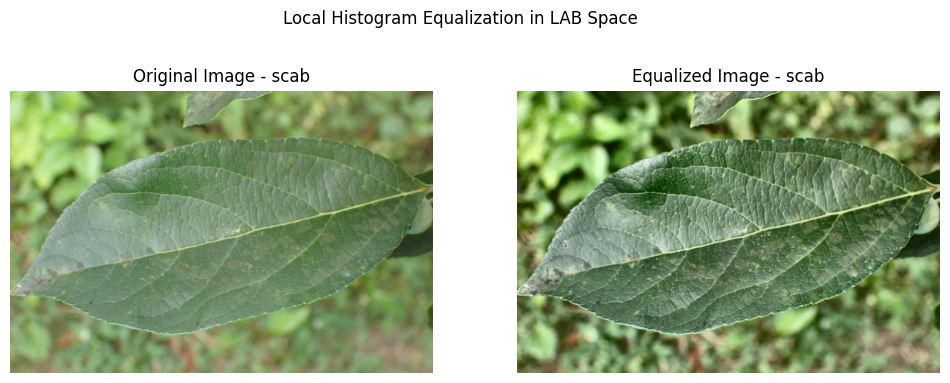

In [314]:
random_image = train_label_df.sample(1).iloc[0, 0]
image_path = os.path.join(train_images_path, random_image)

equalize_hist(image_path)
equalize_hist_lab(image_path)
equalize_local_hist(image_path)

# Making the Problem Simple

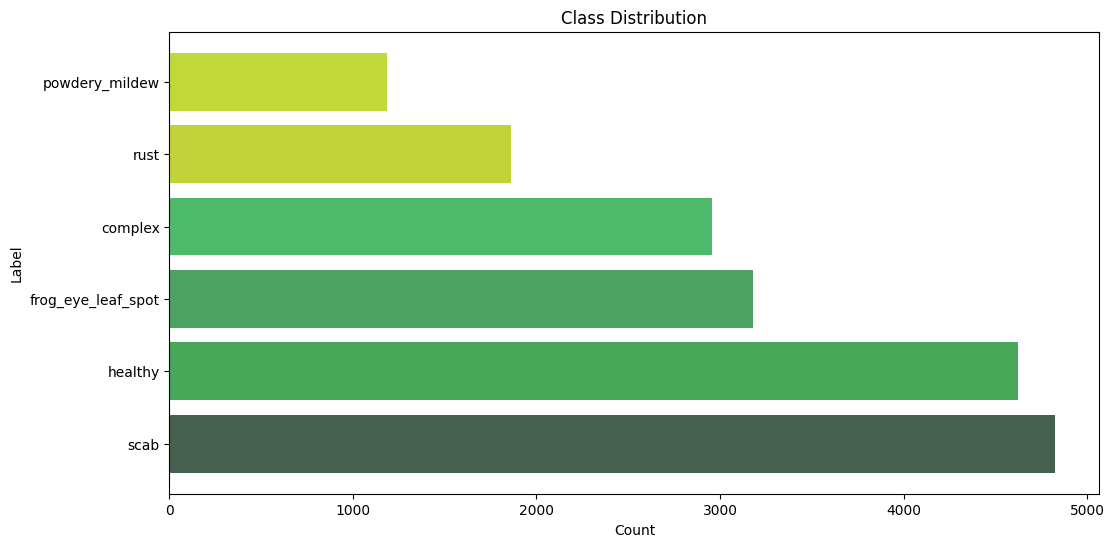

In [264]:
def combine_classes(row):
    if 'complex' in row or ' ' in row:
        return 'complex'
    else:
        return row

train_label_df['labels'] = train_label_df['labels'].apply(combine_classes)
train_label_df.to_csv('/kaggle/working/train_labels.csv', index=False)

label_dist = train_label_df.iloc[:, [1]].value_counts()

label_dist_df = label_dist.reset_index()
label_dist_df.columns = ['Label', 'Count']

colors = ['#455F51', '#48A759', '#4CA263', '#50BA6C', '#C0D43A', '#C0D83A']

plt.figure(figsize=(12, 6))

plt.barh(label_dist_df['Label'], label_dist_df['Count'], color=colors)
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Class Distribution')
plt.show()

# Preprocessing and Resizing

In [265]:
def preprocess(image_file, original_directory, output_directory, target_width, target_height):
    image_path = os.path.join(original_directory, image_file)
    output_path = os.path.join(output_directory, image_file)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = equalize_local_hist(image)
#     image = sharp(image)
    resized_image = cv2.resize(image, (target_width, target_height))
    cv2.imwrite(output_path, resized_image)

In [266]:
def run_preprocessing():
    # Define directories
    input_directory = "/kaggle/input/plant-pathology-2021-fgvc8/train_images"
    output_directory = "/kaggle/working/resized_train_images"

    # Define target dimensions
    target_width = 224
    target_height = 224

    # Create output directory if it doesn't exist or empty it if it exists
    if os.path.exists(output_directory):
        shutil.rmtree(output_directory)
    
    os.makedirs(output_directory)

    # List image files in the original directory
    image_files = [f for f in os.listdir(input_directory)]

    # Determine the number of CPU cores available
    num_cores = multiprocessing.cpu_count()

    # Use all available CPU cores for parallel resizing
    with multiprocessing.Pool(num_cores) as pool:
        pool.starmap(
            preprocess,
            [(image_file, input_directory, output_directory, target_width, target_height) for image_file in image_files]
        )

    print("Finished")

In [267]:
# run_preprocessing()

# Data Preperations

In [268]:
train_df = pd.read_csv("/kaggle/working/train_labels.csv")
datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.2)

In [276]:
# Split the dataset into training (80%), validation (10%), and test (10%) sets
train_temp_df, temp_df = train_test_split(train_df, test_size=0.2, random_state=42)

valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=43)

# Create data generators for the training, validation, and test sets
train_ds = datagen.flow_from_dataframe(
    train_temp_df,
    directory='/kaggle/working/resized_train_images',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=44  # Use a different seed
)

valid_ds = datagen.flow_from_dataframe(
    valid_df,
    directory='/kaggle/working/resized_train_images',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=45  # Use a different seed
)

test_ds = datagen.flow_from_dataframe(
    test_df,
    directory='/kaggle/working/resized_train_images',
    x_col='image',
    y_col='labels',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  # No need to shuffle test data
)

Found 11924 validated image filenames belonging to 6 classes.
Found 372 validated image filenames belonging to 6 classes.
Found 1864 validated image filenames belonging to 6 classes.


# Creating Model

In [318]:
def construct_model():
    # Define the CNN model
    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully connected layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(6, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    model.summary()
    return model

model = construct_model()

plot_model(model, to_file='/kaggle/working/model_diagram.png', show_shapes=True, show_layer_names=True)
print("\nModel diagram saved as 'model_diagram.png'")


Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_40 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_41 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 26, 26, 128)    

# Creating Model with L2

In [278]:
def construct_model(l2_lambda=0.01):
    # Define the CNN model
    model = models.Sequential()

    # Convolutional layers with L2 regularization
    model.add(layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda), input_shape=(224, 224, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(layers.Flatten())

    # Fully connected layers with L2 regularization
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_lambda)))
    model.add(layers.Dense(6, activation='softmax', kernel_regularizer=regularizers.l2(l2_lambda)))

    # Compile the model
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Print model summary
    model.summary()
    return model

# Create the model with L2 regularization
model_with_l2 = construct_model(l2_lambda=0.02)


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_35 (MaxPoolin  (None, 26, 26, 128)    

# Fiting Model

In [279]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU is available")
else:
    print("GPU is not available")
    
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


GPU is available
Num GPUs Available:  2


In [284]:
train_steps = len(train_ds)
valid_steps = len(valid_ds)

history = model.fit(
    train_ds,
    steps_per_epoch=train_steps,
    validation_data=valid_ds,
    validation_steps=valid_steps,
    epochs=20
)

Epoch 1/20
373/373 [==============================] - 133s 351ms/step - loss: 1.4618 - accuracy: 0.4091 - val_loss: 1.3980 - val_accuracy: 0.4301
Epoch 2/20
373/373 [==============================] - 131s 350ms/step - loss: 1.2266 - accuracy: 0.5201 - val_loss: 1.2189 - val_accuracy: 0.5215
Epoch 3/20
373/373 [==============================] - 131s 350ms/step - loss: 0.9933 - accuracy: 0.6134 - val_loss: 1.0813 - val_accuracy: 0.5484
Epoch 4/20
373/373 [==============================] - 131s 350ms/step - loss: 0.8597 - accuracy: 0.6638 - val_loss: 0.9449 - val_accuracy: 0.6129
Epoch 5/20
373/373 [==============================] - 130s 349ms/step - loss: 0.7658 - accuracy: 0.7029 - val_loss: 0.9288 - val_accuracy: 0.5914
Epoch 6/20
373/373 [==============================] - 129s 346ms/step - loss: 0.7124 - accuracy: 0.7246 - val_loss: 0.8435 - val_accuracy: 0.6828
Epoch 7/20
373/373 [==============================] - 129s 345ms/step - loss: 0.6726 - accuracy: 0.7395 - val_loss: 0.9391 -

# Loss and Accuracy Plot

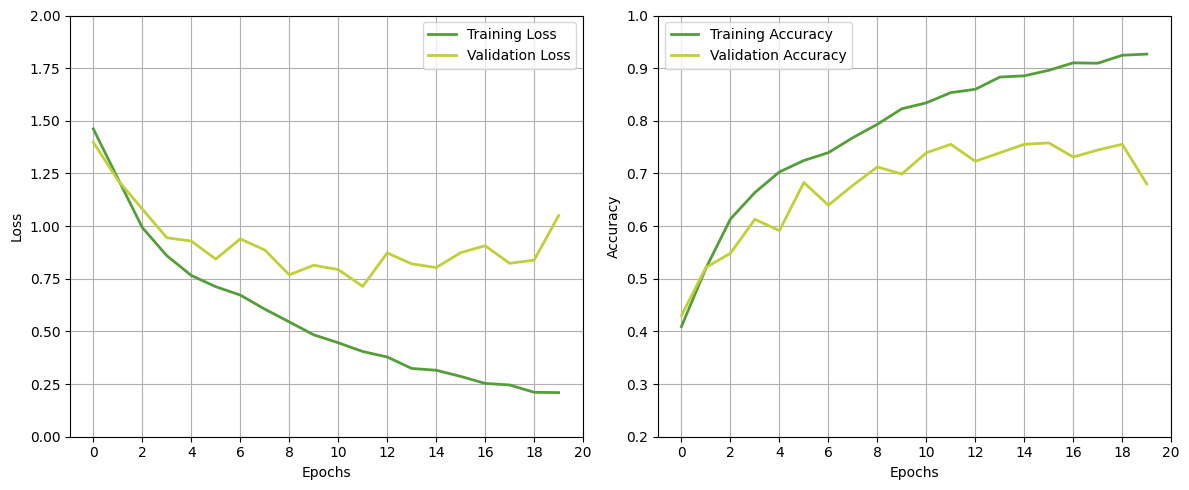

In [306]:
plt.figure(figsize=(12, 5))

# Subplot 1: Loss vs. Epochs
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='#549E39', linewidth=2.0)
plt.plot(history.history['val_loss'], label='Validation Loss', color='#C0CF3A', linewidth=2.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 2)
plt.xticks(range(0, 22, 2))
plt.legend()
plt.grid(True)

# Subplot 2: Accuracy vs. Epochs
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#549E39', linewidth=2.0)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#C0CF3A', linewidth=2.0)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0.2, 1)
plt.yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.xticks(range(0, 22, 2))
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# Save the Model

In [288]:
model.save("/kaggle/working/afd_v5.h5")

# Load and Test the Model

In [289]:
# Load the trained model
loaded_model = tf.keras.models.load_model("/kaggle/working/afd_v5.h5")

# Make predictions on the test dataset
y_pred = loaded_model.predict(test_ds)

59/59 [==============================] - 19s 327ms/step


# Get Label from Prediction

In [307]:
# Getting predicted class
y_pred = np.array(y_pred)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_classes = list(y_pred_classes)

# Getting true class
y_true = test_ds.labels

# Getting class labels
class_labels = list(test_ds.class_indices.keys())

# Draw Confusion Matrix

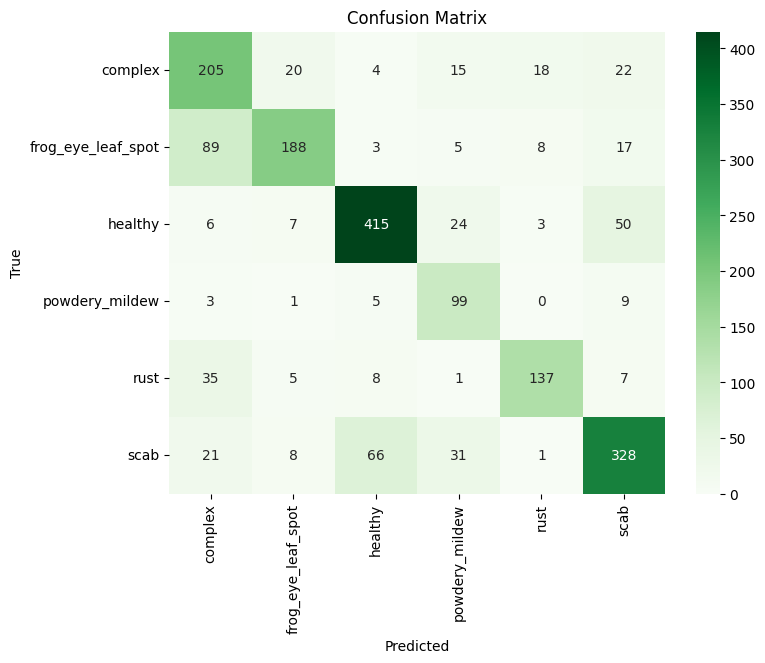

                    precision    recall  f1-score   support

           complex       0.57      0.72      0.64       284
frog_eye_leaf_spot       0.82      0.61      0.70       310
           healthy       0.83      0.82      0.83       505
    powdery_mildew       0.57      0.85      0.68       117
              rust       0.82      0.71      0.76       193
              scab       0.76      0.72      0.74       455

          accuracy                           0.74      1864
         macro avg       0.73      0.74      0.72      1864
      weighted avg       0.75      0.74      0.74      1864



In [310]:
# Calculate the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mtx, annot=True, fmt='d', cmap='Greens', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
class_labels = list(test_ds.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

# Test Saved Model on Single Image for API

1/1 [==============================] - 0s 81ms/step

Image with Predicted Label



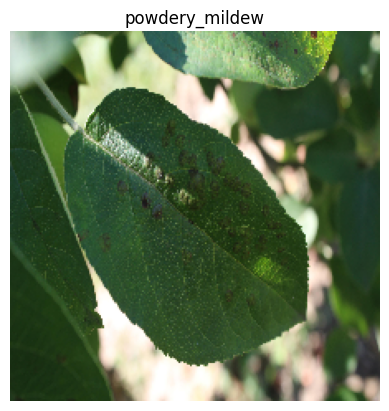

In [313]:
model = tf.keras.models.load_model("/kaggle/working/afd_v5.h5")
# Load and preprocess the input image using OpenCV
img_path = '/kaggle/input/plant-pathology-2021-fgvc8/test_images/85f8cb619c66b863.jpg'
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img = cv2.resize(img, (224, 224))
img_array = np.expand_dims(img, axis=0)

# Make predictions
prediction = model.predict(img_array)

# Dsiplay Results
prediction = np.array(prediction)
prediction = np.argmax(prediction, axis=1)
prediction = list(prediction)

predicted_class = class_labels[prediction[0]]

print('\nImage with Predicted Label\n')

plt.imshow(img)
plt.title(predicted_class)
plt.axis('off')
plt.show()